# Media móvil para el suavizado de una señal de tráfico web
© 2018 Juan M. Fonseca-Solís

## Introducción
El monitoreo del tráfico de red en un servidor web es una tarea necesaria para asegurar que la cantidad de usuarios conectados simultáneamente no exceda la capacidad del equipo instalado. Cuando el sistema recibe más solicitudes de las que puede procesar produce tiempos de respuesta lentos que empeoran la experiencia del usuario, y a largo plazo, generan la pérdida de clientes. Para mitigar este problema es necesario implementar alertas automáticas que ayuden a identificar los momentos en los que la señal de tiempo vs. número de conexiones establecidas excede un umbral definido, y deba procederse a considerar opciones como agregar un balanceador de carga, aumentar el CPU y la memoria, u optimizar la base de datos [1]. Un ejemplo de este control se presenta a continuación:

Populating the interactive namespace from numpy and matplotlib


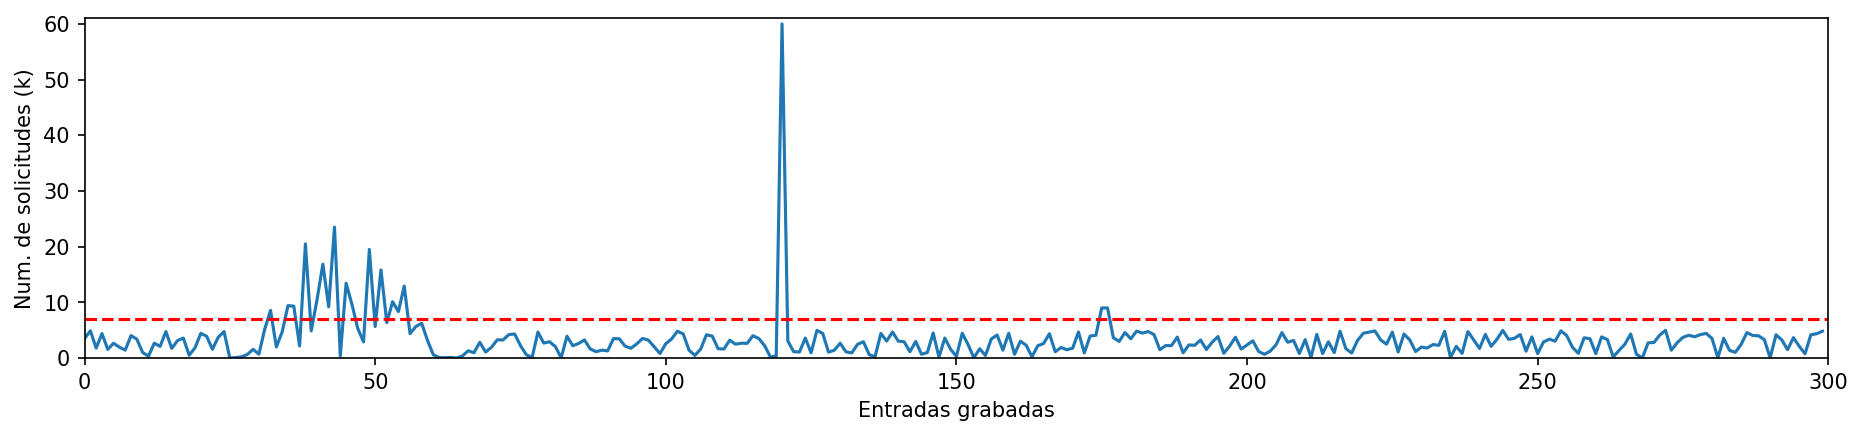

In [16]:
%pylab inline
%matplotlib inline
import numpy as np;
N = 300
x = np.random.rand(N)*5
x[25:65] = np.multiply(x[25:65],6*np.hanning(40))
x[120] = 60
x[175:177] = 9
figure(figsize=(15, 3), dpi= 150, facecolor='w', edgecolor='k')
plot(x)
xlim([0,N])
ylim([0,max(x)+1])
axhline(y=7, color='r', linestyle='--')
xlabel('Entradas grabadas')
ylabel('Num. de solicitudes (k)')
show()

Donde los picos en los instantes 40, 120 y 175 son reconocidos como eventos indeseados y son candidatos para la emisión de una alerta. Sin embargo, el instante 175 representa más bien un *evento transitorio* que no representa una amenaza real pues tarda apenas unos pocos minutos y su amplitud no es tan alta como el resto de picos. 

## Media móvil
Para ignorar los eventos transitorios, y evitar crear alertas por falsos positivos, se suele usar una técnica de "suavizado" de datos llamada la media móvil (MA, por sus siglas en inglés). Esta técnica se define como sigue [2]:
$$
    y[n] = \frac{1}{M}\sum_{m=0}^{M}{x[n-m]},\quad (1)
$$
donde $M$ es la cantidad de vecinos a considerar en el promedio. No se consideran los vecinos posteriores a la muestra actual pues el procesamiento se realiza de manera causal (es decir, no se pueden usar muestras que no han sido grabadas). Este método numérico está disponible en la mayoría de paquetes de visualización de datos, entre ellos, Graphite (https://graphite.readthedocs.io/en/latest/functions.html#graphite.render.functions.movingAverage). Con $M=10$ vecinos, la ecuación anterior permite obtener la siguiente version suavizada:

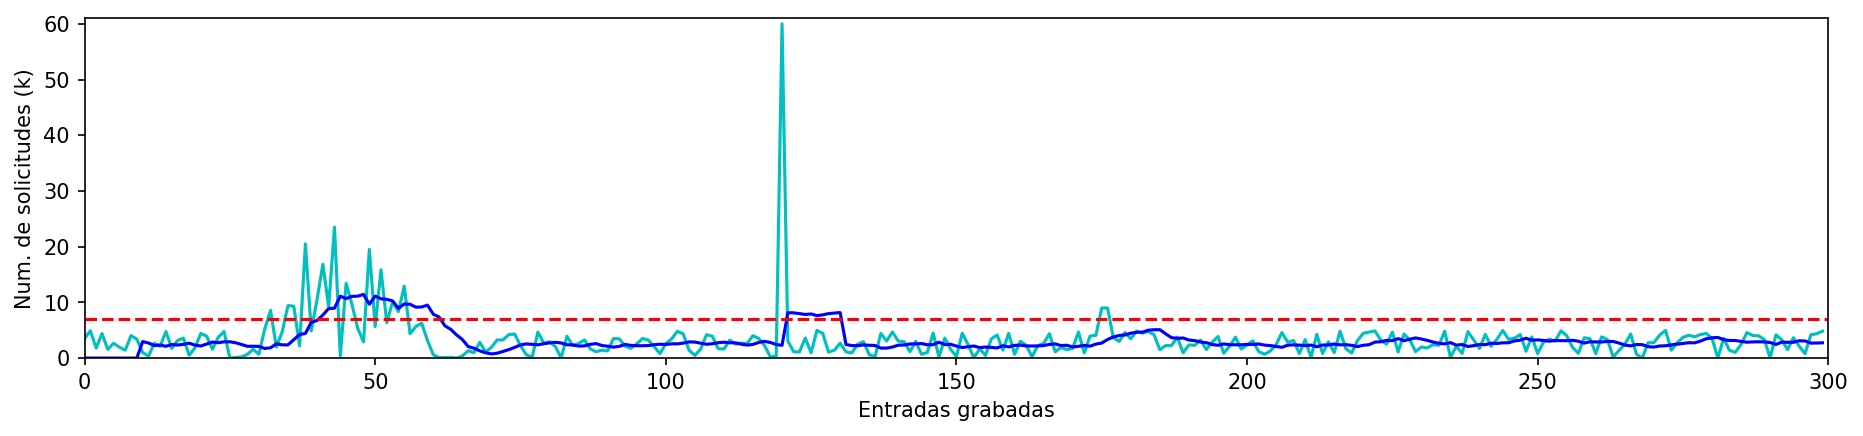

In [17]:
y = [0.0]*N
M=10
for n in range(M,N):
    y[n] = np.sum(x[n-M:n])/M
figure(figsize=(15, 3), dpi= 150, facecolor='w', edgecolor='k')
plot(x,'c')
plot(y,'b')
xlim([0,N])
ylim([0,max(x)+1])
axhline(y=7, color='r', linestyle='--')
xlabel('Entradas grabadas')
ylabel('Num. de solicitudes (k)')
show()

Donde se observa que el pico en 175 a sido eliminado y los eventos cerca 40 y 120 se conservan, como es de esperar. 

## Retraso temporal

Una pregunta que surge al usar el MA es saber cuántos vecinos deben elegirse para la ventana de análisis. Para responderla es necesario entender el significado de los términos: periodo de muestreo de datos y *retraso de grupo*. El primero se denota como $T_s$ y se define como el tiempo transcurrido entre cada par de muestras (el recíproco $F_s=1/T_s$ se llama frecuencia de muestreo), y el segundo corresponde a un retardo, del número de muestras, que distorsiona de forma indeseada la señal suavizada. El retraso de grupo multiplicado por el periodo de muestreo brinda el retraso temporal que sufre la señal procesada. Usando un periodo de muestreo de $T_s=5$ minutos se obtiene un retraso de grupo de casi una hora ($MT_s=50$ minutos) en la emisión de las alertas, y usando $T_s=1$ minuto, el retraso es de apenas 10 minutos. Una forma de mitigar el retraso de grupo es aumentar el periodo de muestreo, lo que genera más muestras por unidad de tiempo, pero sacrifica el espacio disponible para guardar datos en la bitácora. Es decisión del administrador del sistema determinar el retraso de grupo que puede admitir de acuerdo a la urgencia en la emisión de las alertas.  

## Retraso de grupo del MA

Para entender por qué el MA tiene un retraso de grupo igual a $M$ es necesario estudiar el método numérico en el dominio frecuencial. Usando la transformada Z sobre la ecuación (1) se obtiene la siguiente expresión:
$$
    Y(z) = \frac{1}{M}\sum_{m=0}^{M}{X(z)z^{-m}},
$$
y acomodando los términos $Y(z)$ y $X(z)$ se puede obtener la respuesta en frecuencia del filtro:
$$
    H(z) = \frac{Y(z)}{X(z)} = \frac{1}{M}\sum_{m=0}^{M}{z^{-m}},
$$
(...)

## Referencias
1. Brian Jackson. How to Effectively Monitor and Scale for Website Traffic. KeyCDN. 10 de enero de 2017. URL: https://www.keycdn.com/blog/scale-website-traffic/ (última vez consultado el 16 de setiembre de 2018)
2. John G. Proakis y Dimitris K. Manolakis. Digital Signal Processing (4 edición). Prentice-Hall, Inc., Upper Saddle River, NJ, USA. 2006